<a id='start'></a>

# Анализ деятельности и повышение показателей эффективности сервиса аренды самокатов GoFast

## Описание проекта

**Цель проекта:** проанализировать данные пользователей сервиса аренды самокатов GoFast и протестировать гипотезы по пользователям с платной подпиской и без неё с целью улучшения показателей деятельности компании.

**Описание данных:**
1. **база данных users:**
    - *user_id* - уникальный идентификатор пользователя;
    - *name* - имя пользователя;
    - *age* - возраст;
    - *city* - город;
    - *subscription_type* - тип подписки (free, ultra);
2. **база данных rides:**
    - *user_id* - уникальный идентификатор пользователя;
    - *distance* - расстояние, которое пользователь проехал в текущей сессии (в метрах);
    - *duration* - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
    - *date* - дата совершения поездки;
3. **база данных sibscriptions:**
    - *subscription_type* - тип подписки;
    - *minute_price* - стоимость одной минуты поездки по данной подписке;
    - *start_ride_price* - стоимость начала поездки;
    - *subscription_fee* - стоимость ежемесячного платежа.

**Алгоритм исследования:**
1. [Загрузка данных](#step1)
2. [Предобработка данных](#step2)
3. [Исследовательский анализ данных](#step3)
4. [Объединение данных](#step4)
5. [Подсчёт выручки](#step5)
6. [Проверка гипотез](#step6)
7. [Анализ распределений](#step7)
8. [Выводы исследования](#step8)
9. **[Ключевые выводы для бизнеса](#step9)**

## Исследование

<a id=step1></a>

### 1. Загрузка данных

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom, norm
import numpy as np
import math
from math import factorial
from math import sqrt

#### *База данных users*

In [2]:
# сохраним поочерёдно каждый CSV-файл в переменную, выведем на экран 5 первых строк датафрейма
# и общую информацию о нём

In [3]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('C:/Users/Александра/practicum/users_go.csv')

users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# зафиксируем число записей в датафрейме и выведем общую информацию о базе данных

users_count1 = len(users)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


#### *База данных rides*

In [5]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
except:
    rides = pd.read_csv('C:/Users/Александра/practicum/rides_go.csv', parse_dates=['date'])

rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_count1 = len(rides)
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#### *База данных subscriptions*

In [7]:
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('C:/Users/Александра/practicum/subscriptions_go.csv')

subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_count1 = len(subscriptions)
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Зафиксируем наблюдения после загрузки данных:
- датафрейм **users** содержит данные о пользователях: уникальный идентификатор пользователя, имя пользователя, возраст, город и тип подписки (free, ultra). В датафрейме **1 565 записей**, пропущенных значений по переменным не наблюдается. Среди переменных присутствуют 2 целочисленных параметра *(user_id, age)* и 3 строковых *(name, city, subscription_type)*;
- датафрейм **rides** содержит данные о поездках: уникальный идентификатор пользователя; расстояние, которое пользователь проехал в текущей сессии; продолжительность сессии; дата совершения поездки. В таблице **18 068 записей** - пропущенных значений на первый взгляд также не наблюдается. Среди параметров: одна целочисленная переменная *(user_id)*, 2 переменные с плавающей точкой *(distance, duration)* и одна строковая переменная *(date)*;
- датафрейм **subscriptions** содержит всего **2 записи**, соответствющих двум вариантам использования сервиса: тип подписки, стоимость одной минуты поездки по данной подписке, стоимость начала поездки, стоимость ежемесячного платежа. Датафрейм содержит 3 целочисленных параметра *(minute_price, start_ride_price, subscription_fee)* и одну переменную строкового типа *(subscription_type)*.

<a id=step2></a>

### 2. Предобработка данных

#### 2.1. Создание столбца с месяцем поездки

Для удобства дальнейшего анализа создадим в датафрейме **rides** новый столбец *month*, который будет содержать номер месяца на основе даты поездки из столбца *date*.

In [9]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [10]:
first_date = rides['date'].min()
last_date = rides['date'].max()

print('Начало сбора данных:', first_date)
print('Окончание сбора данных:', last_date)
print('Данные собраны за период:', last_date-first_date)

Начало сбора данных: 2021-01-01 00:00:00
Окончание сбора данных: 2021-12-30 00:00:00
Данные собраны за период: 363 days 00:00:00


Отметим, что **датафрейм rides содержит данные о поездках, совершённых в течение 2021 года**.

#### 2.2. Проверка на наличие пропущенных значений и дубликатов

##### *База данных users*

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропущенных значений в датафрейме **users** нет. Проверим наличие явных дубликатов.

In [12]:
users.duplicated().sum()

31

In [13]:
# избавимся от дубликатов и выведем на экран новое количество записей в датафрейме

users = users.drop_duplicates()
users_count2 = len(users)

print(f'Из датафрейма users был удалён {users_count1 - users_count2} дубликат, \
что составляет {round((users_count1 - users_count2)/users_count1*100, 2)}% изначальной выборки.')
print()
users.info()

Из датафрейма users был удалён 31 дубликат, что составляет 1.98% изначальной выборки.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


##### *База данных rides*

In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
rides.duplicated().sum()

0

В датафрейме **rides** нет ни пропущенных значений, ни дубликатов.

##### *База данных subscriptions*

In [16]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [17]:
subscriptions.duplicated().sum()

0

В датафрейме **subscriptions** также нет ни пропущенных значений, ни дубликатов.

Можно переходить к исследовательскому анализу данных.

<a id=step3></a>

### 3. Исследовательский анализ данных

В исследовательском анализе данных оценим распределение различных переменных и проверим их на наличие возможных выбросов.

#### *3.1. частота встречаемости городов (city)*

In [18]:
# выведем список уникальных значений переменной city датафрейма users

print(users['city'].nunique())
users['city'].value_counts()

8


Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

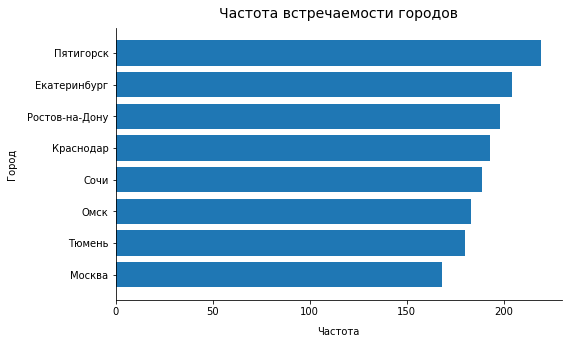

In [19]:
# построим гистограмму распределения переменной на основе сводной таблицы

users_pivot = (users
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .sort_values(by='user_id')
)

users_pivot.columns = ['count']

plt.figure(figsize=(8, 5))
plt.barh(users_pivot.index, users_pivot['count'])
plt.title('Частота встречаемости городов', fontsize=14, pad=10)
plt.ylabel('Город', labelpad=10)
plt.xlabel('Частота', labelpad=10)
sns.despine()
plt.show()

In [20]:
# посчитаем долю пользователей по городам

users_pivot['city_share'] = round(users_pivot['count'] / len(users), 3) * 100
users_pivot

,count,city_share
city,,
Москва,168,11.0
Тюмень,180,11.7
Омск,183,11.9
Сочи,189,12.3
Краснодар,193,12.6
Ростов-на-Дону,198,12.9
Екатеринбург,204,13.3
Пятигорск,219,14.3


Можно отметить, что **больше всего пользователей за период наблюдений было зафиксировано в Пятигорске** (219 человек), **в то время как меньше всего - в Москве** (168 человек).

#### *3.2. соотношение пользователей с подпиской и без подписки (subscription_type)*

In [21]:
# изучим количество пользователей с платной подпиской (ultra) и без неё (free)

users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [22]:
# посмотрим, какую долю всех пользователей сервиса составляют владельцы платной подписки

round(users[users['subscription_type'] == 'ultra']['user_id'].count() / len(users), 3) * 100

45.6

Количество пользователей с платной подпиской и без неё примерно одинаково, однако **владельцев платной подписки всё же меньше: они составляют 45,6% от всей выборки**.

Отобразим соотношение пользователей с платной подпиской и без неё на графике.

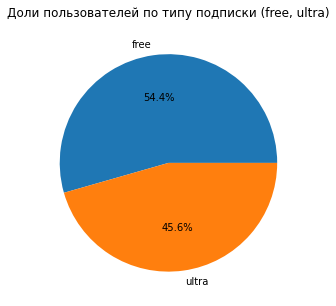

In [23]:
users['subscription_type'].value_counts().plot(kind='pie', figsize=(5, 5), autopct='%.1f%%')
plt.title('Доли пользователей по типу подписки (free, ultra)', size=12, pad=10)
plt.ylabel(None)
plt.show()

#### *3.3. возраст пользователей (age)*

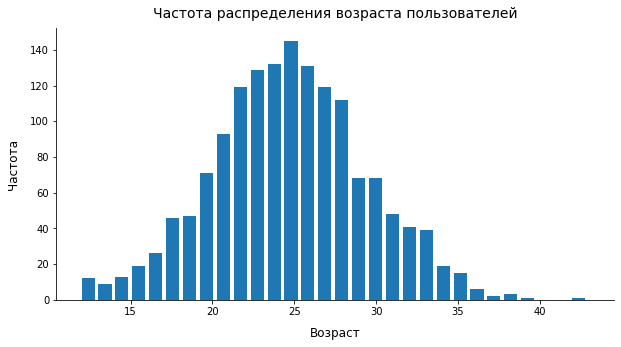

In [24]:
# визуализируем распределение переменной age датафрейма users

plt.figure(figsize=(10, 5))
plt.hist(users['age'], bins=30, width=0.8)
plt.title('Частота распределения возраста пользователей', size=14, pad=10)
plt.xlabel('Возраст', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
sns.despine()
plt.show()

Распределение переменной *age* напоминает нормальное с центром в значении 25. Явных выбросов при этом не наблюдается. Проверим это на графике боксплот.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Минимальный возраст пользователей составляет 12 лет.
Максимальный возраст пользователей составляет 43 года.



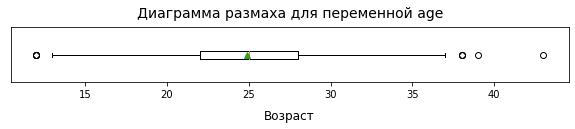

In [25]:
# построим боксплот для переменной age, проанализируем пятичисловую сводку
# и выведем минимальное и максимальное значения, которые принимает переменная

print(users['age'].describe())
print()
print('Минимальный возраст пользователей составляет', users['age'].min(), 'лет.')
print('Максимальный возраст пользователей составляет', users['age'].max(), 'года.')
print()
plt.figure(figsize=(10, 1))
plt.boxplot(users['age'], vert=False, showmeans=True)
plt.title('Диаграмма размаха для переменной age', size=14, pad=10)
plt.xlabel('Возраст', fontsize=12, labelpad=10)
plt.yticks([0])
plt.show()

Несмотря на то, что на графике некоторые значения вышли за пределы интервала [Q1 - 1.5IQR; Q3 + 1.5IQR], мы не можем отнести их к аномальным значениям. Арендателю самоката может быть как 43 года, так и 12 лет. Вопрос возраста, с которого клиенты могут начать пользоваться сервисом, стоит адресовать службе тех. поддержки.

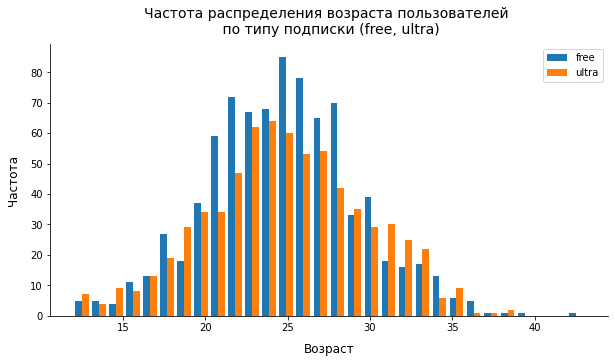

In [26]:
# посмотрим на распределение возраста пользователей в разбивке по типу подписки

free_users = users[users['subscription_type'] == 'free']
ultra_users = users[users['subscription_type'] == 'ultra']

plt.figure(figsize=(10, 5))
plt.hist([free_users['age'], ultra_users['age']], label=['free', 'ultra'], bins=30)
plt.title('Частота распределения возраста пользователей \n по типу подписки \
(free, ultra)', fontsize=14, pad=10)
plt.xlabel('Возраст', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.legend(loc='upper right')
sns.despine()
plt.show()

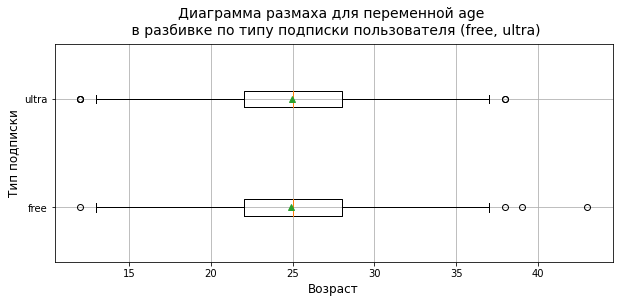

In [27]:
# изучим данное распределение на боксплотах

plt.figure(figsize=(10, 4))
plt.boxplot([free_users['age'], ultra_users['age']], labels=['free', 'ultra'], 
            vert=False, showmeans=True)
plt.title('Диаграмма размаха для переменной age \n в разбивке по типу подписки \
пользователя (free, ultra)', fontsize=14, pad=10)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Тип подписки', fontsize=12)
plt.grid()
plt.show()

Можно отметить, что средний возраст обеих подгрупп находится на уровне 25 лет. В выборке пользователей без платной подписки находится чуть больше людей старше 38 лет, однако это не представляет собой один из факторов различия для обозначенных подгрупп.

#### *3.4. расстояние, которое пользователь преодолел за одну поездку (distance)*

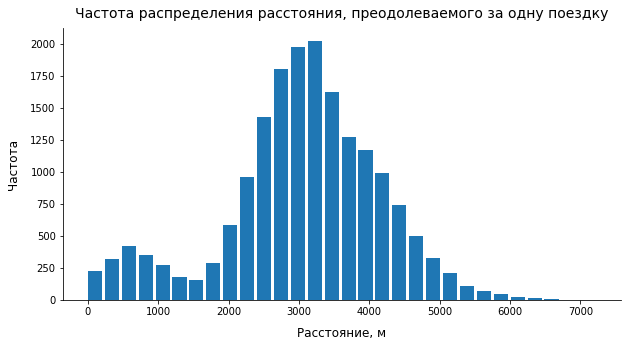

In [28]:
# изучим распределение переменной distance датафрейма rides

plt.figure(figsize=(10, 5))
plt.hist(rides['distance'], bins=30, width=200)
plt.title('Частота распределения расстояния, преодолеваемого за одну поездку',
         fontsize=14, pad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.xlabel('Расстояние, м', fontsize=12, labelpad=10)
sns.despine()
plt.show()

В переменной *distance* отражено то расстояние, которое пользователь проехал за одну сессию (в метрах). Распределение меньше напоминает нормальное: несмотря на пик частоты на уровне **3 100 метров**, в левой части графика наблюдается небольшое увеличение частоты на уровне **700 метров**.

Можно **предположить, что более короткие поездки чаще совершают пользователи без подписки**, чтобы сэкономить на поездке. Т.к. поездок, совершённых пользователями без подписки, в датафрейме rides существенно больше, то из-за них мы видим второй пик частоты на уровне 700 м.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64



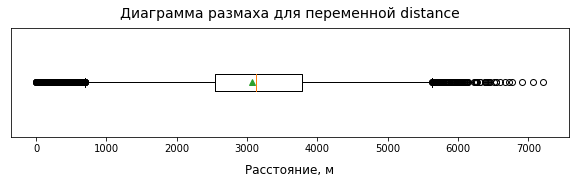

In [29]:
# проанализируем пятичисловую сводку переменной и построим боксплот

print(rides['distance'].describe())
print()
plt.figure(figsize=(10, 2))
plt.boxplot(rides['distance'], vert=False, showmeans=True)
plt.title('Диаграмма размаха для переменной distance', fontsize=14, pad=10)
plt.xlabel('Расстояние, м', fontsize=12, labelpad=10)
plt.yticks([0])
plt.show()

In [30]:
# посчитаем границы интервала [Q1 - 1.5IQR; Q3 + 1.5IQR]

percentile_75 = 0.75
percentile_25 = 0.25

q3 = rides['distance'].quantile(percentile_75)
q1 = rides['distance'].quantile(percentile_25)
iqr = q3 - q1

high_limit = q3 + 1.5 * iqr
low_limit = q1 - 1.5 * iqr

print(f'Значения ниже, чем {round(low_limit, 1)} м, \
и выше, чем {round(high_limit, 1)} м, считаются выбросами.')

Значения ниже, чем 693.7 м, и выше, чем 5625.7 м, считаются выбросами.


Исходя из графика и пятичисловой сводки, по переменной присутствуют выбросы на уровне **меньше 693.7 м** и **больше 5625.7 м**. Однако не все такие значения можно считать аномальными.

Максимальное значение переменной - чуть больше 7 км. Такое расстояние вполне можно проехать на самокате за одну поездку. Что касается минимального значения (менее 1 м) - такие поездки тоже могли быть (например, пользователь взял самокат и после передумал, или его что-то отвлекло от поездки).

Чтобы точно понять, избавляться ли от выбросов по переменной, проанализируем, как связаны между собой переменные *distance* и *duration* с помощью диаграммы рассеяния.

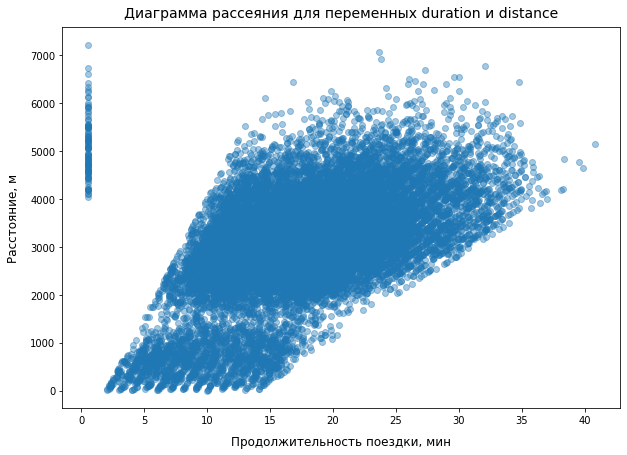


Коэффициент корреляции между переменными: 0.54


In [31]:
plt.figure(figsize=(10, 7))
plt.scatter(rides['duration'], rides['distance'], alpha=0.4)
plt.title('Диаграмма рассеяния для переменных duration и distance', fontsize=14, pad=10)
plt.xlabel('Продолжительность поездки, мин', fontsize=12, labelpad=10)
plt.ylabel('Расстояние, м', fontsize=12, labelpad=10)
plt.show()

print()

print(f"Коэффициент корреляции между переменными: {rides['duration'].corr(rides['distance']).round(2)}")

Между переменными наблюдается средняя корреляция (коэффициент корреляции равен 0.54): по мере увеличения продолжительности поездки расстояние, которое преодолел пользователь за это время, имеет тенденцию к увеличению.

Тем не менее, **на графике отчётливо видны аномалии: поездки, в которых пользователь проехал более 4 км меньше, чем за 1 минуту**. Стоит обратиться к команде тех. поддержки сервиса: возможно, стоит проверить модуль определения расстояния. От данных аномалий избавляться нецелесообразно: выручка компании рассчитывается на основе количества поездок и их продолжительности, поэтому некорректно рассчитанное расстояние не искажает картину.

#### *3.5. продолжительность поездок (duration)*

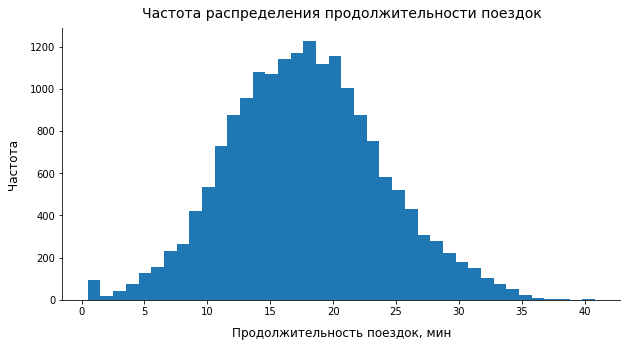

In [32]:
plt.figure(figsize=(10, 5))
plt.hist(rides['duration'], bins=40)
plt.title('Частота распределения продолжительности поездок', fontsize=14, pad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.xlabel('Продолжительность поездок, мин', fontsize=12, labelpad=10)
sns.despine()
plt.show()

Распределение переменной напоминает нормальное с центром в районе 18 мин. Однако наблюдается небольшое увеличение частоты на уровне 0.5 мин.

In [33]:
rides['duration'].value_counts().head()

0.500000     95
22.184080     1
25.866000     1
22.837062     1
19.173800     1
Name: duration, dtype: int64

В датафрейме обнаружено 95 поездок длительностью ровно 30 сек. Это может быть связано с правилами пользования сервисом: например, у пользователя, взявшего самокат в аренду, может быть возможность отменить заказ в течение 0.5 мин. Или же пользователь может проверить самокат на технические неисправности в течение 30 секунд, и если за это время клиент решит не ехать на неисправном самокате, деньги за поездку с него списаны не будут.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64



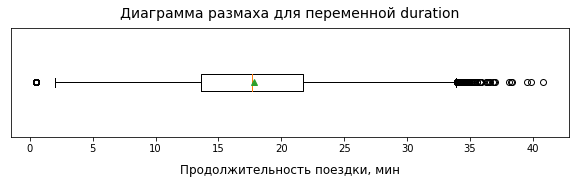

In [34]:
print(rides['duration'].describe())

print()

plt.figure(figsize=(10, 2))
plt.boxplot(rides['duration'], vert=False, showmeans=True)
plt.title('Диаграмма размаха для переменной duration', fontsize=14, pad=10)
plt.xlabel('Продолжительность поездки, мин', fontsize=12, labelpad=10)
plt.yticks([0])
plt.show()

Исходя из графика, поездки длительностью больше ~ 33 мин относятся к выбросам при максимальной длительности поездки почти 41 мин. Однако избавляться от таких записей нет необходимости, т.к. подобные значения не являются аномальными.

#### Выводы по итогам исследовательского анализа

По результатам исследовательского анализа можно сформулировать следующие выводы:
- в датафрейме **rides** агрегирована информация о поездках, совершённых **в течение 2021 года в восьми городах**. За этот период **больше всего поездок было совершено в Пятигорске (219), меньше всего - в Москве (168)**;
- **пользователей с платной подпиской чуть меньше**, чем пользователей без неё (доли распределены как **45.6%** и 54.4% соответственно);
- среднему пользователю сервиса вне зависимости от типа подписки - **25 лет**;
- **расстояние, которое проезжают пользователи, сконцентрировано в двух пиках: ~700 м и ~3100 м**. Это может объясняться тем, что пользователи без подписки чаще совершают более короткие поездки, нежели пользователи с подпиской. Т.к. информации о поездках, совершённых пользователями без подписки, в датафрейме существенно больше, мы можем наблюдать пик более коротких поездок на уровне ~700 м;
- в среднем каждый пользователь тратит на одну поездку **почти 18 мин**.

<a id=step4></a>

### 4. Объединение данных

#### 4.1. Объединение датафреймов

In [35]:
# объединим 3 датафрейма в одну таблицу для удобства дальнейшего анализа

data = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


В самом "длинном" датафрейме **rides** изначально было **18 068 записей**. Следовательно, стоит ориентироваться на эту итоговую размерность после объединения таблиц. Проверим размерность объединённой таблицы и возможные пропуски в ней.

In [36]:
data.shape

(18068, 12)

In [37]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Объединённая таблица содержит столько же записей, сколько изначально было в самом длинном датафрейме - **18 068**.

**Пропусков в объединённой таблице не обнаружено - следовательно, можно говорить об успешном завершении объединения датафреймов.**

#### 4.2. Создание новых датафреймов

In [38]:
# для дальнейшего анализа создадим два отдельных датафрейма:
# с данными о пользователях с подпиской и без неё

free = data[data['subscription_type'] == 'free']
ultra = data[data['subscription_type'] == 'ultra']

print('Датафрейм с пользователями без подписки')
free.info()
print()
print('Датафрейм с пользователями с подпиской')
ultra.info()

Датафрейм с пользователями без подписки
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ 

Получили два датафрейма с данными о поездках в разбивке по типу подписки пользователя.

В датафрейме с данными о пользователях без подписки содержится **11 568 записей**, с данными о пользователях с подпиской - **6 500 записей**.

#### 4.3. Визуализация информации

##### *distance*

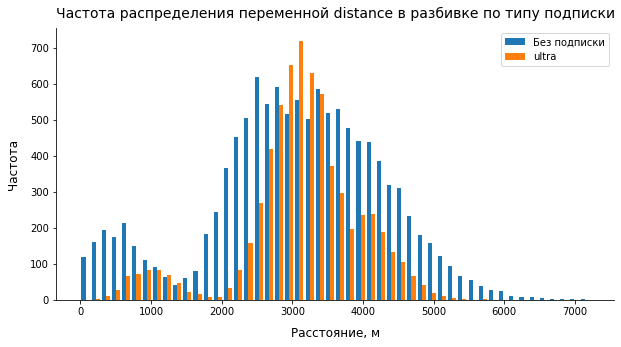

In [39]:
# отобразим распределение переменной distance в разбивке по типу подписки

plt.figure(figsize=(10, 5))
plt.hist([free['distance'], ultra['distance']], label=['Без подписки', 'ultra'], bins=50)
plt.title('Частота распределения переменной distance в разбивке по типу подписки', fontsize=14, pad=10)
plt.xlabel('Расстояние, м', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.legend(loc='upper right')
sns.despine()
plt.show()

Центр распределения с наибольшей частотой для пользователей **без платной подписки (free) находится на уровне 2,5 км**, в то время как центр распределения для пользователей **с платной подпиской находится правее - на уровне 3,1 км**.

Интересно, что в обоих подвыборках наблюдается пик "коротких дистанций": для пользователей без подписки - на уровне 600 м, для пользователей с подпиской - на уровне 1 км. Это может быть связано с целью поездки пользователя. Более длинные поездки пользователи совершают, скорее всего, с целью прогулки, встречи с друзьями и т.д. (чем обусловлен пик в районе 3 км), в то время как более короткие поездки могут быть "деловыми": например, с целью добраться от метро до работы / места встречи и т.д.

##### *duration*

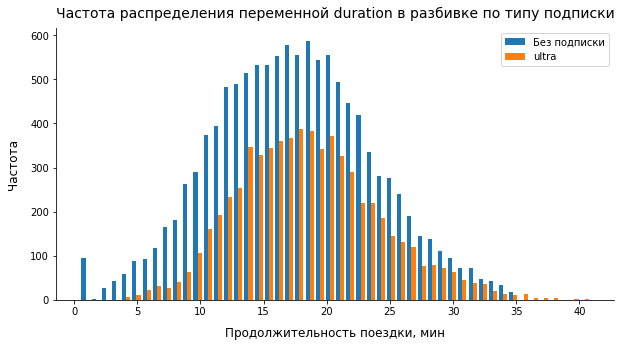

In [40]:
# отобразим распределение переменной duration в разбивке по типу подписки

plt.figure(figsize=(10, 5))
plt.hist([free['duration'], ultra['duration']], label=['Без подписки', 'ultra'], bins=50)
plt.title('Частота распределения переменной duration в разбивке по типу подписки', fontsize=14, pad=10)
plt.xlabel('Продолжительность поездки, мин', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
plt.legend(loc='upper right')
sns.despine()
plt.show()

По графикам видно, что распределение переменной *duration* для пользователей без платной подписки имеет чуть более короткий правый хвост, чем распределение той же переменной для пользователей с платной подпиской. При этом центр распределения продолжительности поездки для пользователей с платной подпиской находится чуть правее, чем для пользователей без подписки. Проверим данное наблюдение с помощью пятичисловых сводок по переменной *duration* для двух подвыборок: пользователи без подписки (FREE) и пользователи с платной подпиской (ULTRA).

In [41]:
print('FREE: пятичисловая сводка для переменной duration')
print(free['duration'].describe())
print()
print('ULTRA: пятичисловая сводка для переменной duration')
print(ultra['duration'].describe())

FREE: пятичисловая сводка для переменной duration
count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

ULTRA: пятичисловая сводка для переменной duration
count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


На основе пятичисловых сводок можем сделать вывод о том, что **в среднем пользователи с подпиской тратят чуть больше времени на одну поездку, чем пользователи без подписки**.

Медианное время одной поездки для пользователей **без подписки составляет 17.3 мин**, для пользователей **с подпиской - 18.2 мин**.

<a id=step5></a>

### 5. Подсчёт выручки

#### 5.1. Создание агрегированного датафрейма

In [42]:
# для переменной duration выполним округление вверх в изначальном датафрейме

data['duration'] = np.ceil(data['duration'])
data['duration'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration, dtype: float64

Создадим датафрейм с агрегированными данными по каждому пользователю за каждый месяц. Новая таблица будет содержать для каждого пользователя за каждый месяц:
- количество поездок *(count)*,
- суммарное расстояние *(sum_distance)*,
- суммарное время *(sum_duration)*,
- тип подписки *(subscription_type)*.

In [43]:
agg_data = (data
            .pivot_table(
                index=['user_id', 'month'],
                values=['distance', 'duration', 'subscription_type'],
                aggfunc={'distance': ['count', 'sum'], 'duration': 'sum', 
                         'subscription_type': 'first'})
            .reset_index()
            .droplevel(1, axis=1)
           )

agg_data.columns = ['user_id', 'month', 'count', 'sum_distance', 
                    'sum_duration', 'subscription_type']
agg_data

,user_id,month,count,sum_distance,sum_duration,subscription_type
0,1,1,2,7027.511294,42.0,ultra
1,1,4,1,754.159807,7.0,ultra
2,1,8,2,6723.470560,46.0,ultra
3,1,10,2,5809.911100,32.0,ultra
4,1,11,3,7003.499363,56.0,ultra
...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,free
11327,1534,8,2,7622.453034,48.0,free
11328,1534,9,1,4928.173852,23.0,free
11329,1534,11,4,13350.015305,78.0,free


In [44]:
# проверим сводную таблицу на наличие пропусков

agg_data.isna().sum()

user_id              0
month                0
count                0
sum_distance         0
sum_duration         0
subscription_type    0
dtype: int64

**В агрегированных данных пропусков не обнаружено** - можем работать с ними дальше.

#### 5.2. Дополнение агрегированного датафрейма

Добавим в агрегированный датафрейм столбец с ежемесячной выручкой на каждого пользователя. Для этого сначала добавим в датафрейм информацию о параметрах оплаты.

In [45]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [46]:
# добавим в agg_data столбцы с параметрами оплаты

agg_data['minute_price'] = np.where(agg_data['subscription_type'] == 'free',
    subscriptions.loc[0, 'minute_price'], subscriptions.loc[1, 'minute_price'])
agg_data['start_ride_price'] = np.where(agg_data['subscription_type'] == 'free',
    subscriptions.loc[0, 'start_ride_price'], subscriptions.loc[1, 'start_ride_price'])
agg_data['subscription_fee'] = np.where(agg_data['subscription_type'] == 'free',
    subscriptions.loc[0, 'subscription_fee'], subscriptions.loc[1, 'subscription_fee'])
agg_data

,user_id,month,count,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,ultra,6,0,199
1,1,4,1,754.159807,7.0,ultra,6,0,199
2,1,8,2,6723.470560,46.0,ultra,6,0,199
3,1,10,2,5809.911100,32.0,ultra,6,0,199
4,1,11,3,7003.499363,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,free,8,50,0
11327,1534,8,2,7622.453034,48.0,free,8,50,0
11328,1534,9,1,4928.173852,23.0,free,8,50,0
11329,1534,11,4,13350.015305,78.0,free,8,50,0


In [47]:
# с помощью отдельной функции создадим столбец для подсчёта выручки 
# по каждому пользователю в каждый месяц

def revenue(row):
    revenue = (row['subscription_fee'] + row['start_ride_price'] * row['count'] +
               row['minute_price'] * row['sum_duration'])
    return revenue
    
agg_data['revenue'] = agg_data.apply(revenue, axis=1)
agg_data

,user_id,month,count,sum_distance,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.511294,42.0,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,free,8,50,0,308.0
11327,1534,8,2,7622.453034,48.0,free,8,50,0,484.0
11328,1534,9,1,4928.173852,23.0,free,8,50,0,234.0
11329,1534,11,4,13350.015305,78.0,free,8,50,0,824.0


In [48]:
# посчитаем суммарную выручку сервиса за 2021 год в разбивке по типу подписки

agg_revenue = agg_data.pivot_table(
    index='subscription_type', 
    values='revenue', 
    aggfunc='sum'
)

agg_revenue['rev_share'] = round(agg_revenue['revenue'] / agg_revenue['revenue'].sum() * 100, 2)

print('Суммарная выручка компании за 2021 год:', agg_revenue['revenue'].sum(), 'руб.')
agg_revenue

Суммарная выручка компании за 2021 год: 3878641.0 руб.


,revenue,rev_share
subscription_type,,
free,2234104.0,57.6
ultra,1644537.0,42.4


Из сводной таблицы видим, что **суммарная выручка сервиса аренды самокатов GoFast за 2021 год составила 3 878 641 руб.**, из которых:
- **57.6%** поступило от пользователей без подписки;
- **42.4%** поступило от пользователей с платной подпиской.

Составив агрегированную таблицу по всем пользователям, можно переходить к статистическому анализу и проверке гипотез исследования.

<a id=step6></a>

### 6. Проверка гипотез

#### 6.1. Гипотеза 1: о равенстве средних по переменной *duration* для двух подвыборок

Перед нами стоит задача проверить гипотезу о равенстве средних по переменной *duration* для двух подвыборок: пользователей с платной подпиской и без неё.

**H0**: Пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки.

**H1**: Пользователи с подпиской тратят **БОЛЬШЕ** времени на поездки, чем пользователи без подписки.

In [49]:
# установим уровень статистической значимости 0.05
alpha = .05

# разделим датафрейм data на 2: содержащий информацию о поездках пользователей
# без подсписки и с платной подпиской
data_free = data[data['subscription_type'] == 'free']
data_ultra = data[data['subscription_type'] == 'ultra']

# проведём тест для независимых выборок о равенстве средних 
#двух генеральных совокупностей
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

# сравним полученный p-value с установленным уровнем статистической значимости
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.495945372073663e-34
Отвергаем нулевую гипотезу


Исходя из результатов теста, на 5%-ном уровне значимости мы **отвергаем нулевую гипотезу** о том, что средняя продолжительность поездки пользователей с подпиской равна средней продолжительности поездки пользователей без подписки.

На основе проведённого теста есть основания сформулировать вывод в пользу альтернативной гипотезы: **пользователи с платной подпиской в среднем тратят больше времени на одну поездку, чем пользователи без подписки**.

Не учитывая стоимость подписки и старта поездки, за каждую минуту поездки пользователь с подпиской приносит компании меньше денег (6 р.), чем пользователь без подписки (8 р.). Тем не менее, с учётом стоимости подписки (199 р. / мес.) и того, что пользователи с платной подпиской в среднем тратят больше времени на одну поездку, то в расчёте на поездку (а не на минуту) пользователь с платной подпиской приносит бизнесу больше денег, чем пользователь без неё.

Проверим данный вывод, рассчитав среднюю выручку, которую приносят пользователи с подпиской и без неё в расчёте на одну поездку.

In [50]:
rev_per_ride = agg_data.pivot_table(
                index='subscription_type',
                values=['revenue', 'count'],
                aggfunc='sum'
)

rev_per_ride['rev_per_ride'] = rev_per_ride['revenue'] / rev_per_ride['count']
rev_per_ride

,count,revenue,rev_per_ride
subscription_type,,,
free,11568,2234104.0,193.127939
ultra,6500,1644537.0,253.005692


На основе полученных данных делаем вывод: **в среднем пользователь с платной подпиской совершает более длинные поездки и приносит сервису больше выручки в расчёте на одну поездку**.

#### 6.2. Гипотеза 2: о равенстве переменной *distance* заданному числу для пользователей с подпиской

**H0**: Пользователи с подпиской проезжают в среднем **3 130 метров** за одну поездку.

**H1**: Пользователи с подпиской проезжают в среднем **БОЛЬШЕ**, чем 3 130 метров за одну поездку.

In [51]:
mu = 3130
alpha = .05

results_2 = st.ttest_1samp(data_ultra['distance'], mu, alternative='greater')

print('p-значение:', results_2.pvalue)

if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


По результатам теста нам **не удалось отвергнуть нулевую гипотезу** в пользу альтернативной на 5%-ном уровне значимости.

Проведём дополнительный тест с левосторонней гипотезой.

**H0**: Пользователи с подпиской проезжают в среднем **3 130 метров** за одну поездку.

**H1**: Пользователи с подпиской проезжают в среднем **МЕНЬШЕ**, чем 3 130 метров за одну поездку.

In [52]:
alpha = .05
mu = 3130

results = st.ttest_1samp(data_ultra['distance'], mu, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502145
Не удалось отвергнуть нулевую гипотезу


При использовании левосторонней альтернативной гипотезы нам также **не удалось отвергнуть нулевую гипотезу**. Тем не менее, отметим, что при 10%-ном уровне значимости (alpha = .1) p-value окажется уже меньше alpha => нулевую гипотезу удастся отвергнуть в пользу альтернативной:


In [53]:
alpha = .1
mu = 3130

results = st.ttest_1samp(data_ultra['distance'], mu, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502145
Отвергаем нулевую гипотезу


Формулируем вывод: **с 90%-ной вероятностью в генеральной совокупности пользователи с подпиской проезжают в среднем меньше 3 130 метров за одну поездку**.

#### 6.3. Гипотеза 3: о равенстве средних по переменной *revenue* для двух подвыборок

Необходимо протестировать гипотезу о равенстве средних ежемесячной выручки, которую получает компания от пользователей с платной подпиской и без неё.

**H0**: Ежемесячная выручка, полученная от пользователей с платной подпиской, равна ежемесячной выручке, полученной от пользователей без платной подписки.

**H1**: Ежемесячная выручка, полученная от пользователей с платной подпиской, **БОЛЬШЕ** ежемесячной выручки, полученной от пользователей без платной подписки.

In [54]:
# разделим агрегированный датафрейм agg_data на 2: с информацией о пользователях
# с платной подпиской и без неё
agg_data_free = agg_data.query('subscription_type == "free"')
agg_data_ultra = agg_data.query('subscription_type == "ultra"')

alpha = .05

results_3 = st.ttest_ind(
    agg_data_ultra['revenue'], agg_data_free['revenue'], 
    alternative='greater')

print('p-значение:', results_3.pvalue)

if results_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


На основе результатов теста мы **отвергаем нулевую гипотезу** о том, что ежемесячная выручка, полученная от пользователей с платной подпиской, равна ежемесячной выручке, полученной от пользователей без платной подписки.

Нулевая гипотеза отвергается в пользу альтернативной: **ежемесячная выручка, получаемая от пользователей с платной подпиской, БОЛЬШЕ ежемесячной выручки, получаемой от пользователей без платной подписки**.

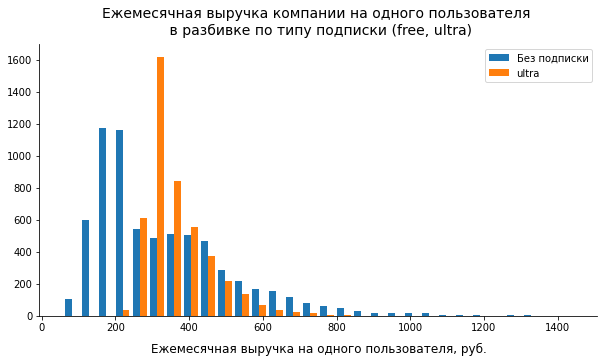

In [55]:
plt.figure(figsize=(10, 5))
plt.hist([agg_data_free['revenue'], agg_data_ultra['revenue']], label=['Без подписки', 'ultra'], bins=30)
plt.title('Ежемесячная выручка компании на одного пользователя \n \
в разбивке по типу подписки (free, ultra)', fontsize=14, pad=10)
plt.xlabel('Ежемесячная выручка на одного пользователя, руб.', fontsize=12, labelpad=10)
plt.legend()
sns.despine()
plt.show()

С помощью графика можно наглядно увидеть превосходство выручки, получаемой на ежемесячной основе от пользователей с платной подпиской, над ежемесячной выручкой, которую получает компания от пользователей без платной подписки.

В соответствии с полученным результатом, **компании имеет смысл распространять информацию о платной подписке среди потенциальных клиентов и проводить мероприятия, направленные на увеличение пользователей, подключивших платную подписку**.

#### 6.4. Гипотеза 4: о сокращении кол-ва обращений в техподдержку

**Задача:** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Решение:**

Т.к. необходимо проверить гипотезу на **одной и той же выборке** после внесения изменений (в данном кейсе - обновление серверов), то необходимо применить **t-тест для двух зависимых выборок**. В связи с тем, что техническая команда предполагает существенное снижение количества обращений в техподдержку после обновления серверов, в качестве альтернативной гипотезы будем использовать левостороннюю гипотезу.

**H0:** Число обращений в техподдержку после обновления серверов не изменилось.

**H1:** Число обращений в техподдержку после обновления серверов стало **меньше**, чем число обращений в техподдержку до обновления.

Предположим, что в датафрейме количество обращений пользователя в техподдержку до и после обновления серверов зафиксировано соответственно в столбцах *support_tickets_before* и *support_tickets_after*.

Код для проведения теста будет выглядеть следующим образом:

```python
# импортируем необходимую библиотеку
from scipy import stats as st

# задаём уровень значимости
alpha = .05

# проводим t-тест для зависимых выборок
results = st.ttest_rel(data['support_tickets_after'], data['support_tickets_before'], alternative='less')

# находим p-value
print('p-значение:', results.pvalue)

# сравниваем p-value с заданным уровнем значимости и интерпретируем результаты теста
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
```

<a id=step7></a>

### 7. Анализ распределений

#### 7.1. Доп. задание отделу маркетинга 1

**Задание**:

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

**Решение:**

В задаче говорится о том, что у пользователя всего два варианта действий после окончания пробного бесплатного периода: либо отказаться от подписки, либо продлить её. Следовательно, в отдельном кейсе мы имеем дело с экспериментом Бернулли, а исход такого эксперимента для всех существующих клиентов представляет собой **биномиальное распределение**.

Основываясь на исторических данных, нам известна вероятность "успеха" (продления подписки) в рамках эксперимента: она равна 10% (значение *p*). Следовательно, вероятность "неудачи" (отказа от продления подписки) равна 100%-10% = 90% (значение *1-p*).

Предположим (умышленно неверно), что если процент успеха равен 10% и нам достаточно, чтобы 100 пользователей продлили подписку, то необходимо разослать промокоды 100 * 10 = 1 000 пользователям.

С помощью метода *cdf* проверим, какова вероятность того, что случайная величина *X* (кол-во пользователей, продливших подписку) окажется >= 100. Для этого посчитаем вероятность, что *X* <= 99, и отнимем полученное значение из 1.

In [56]:
1 - st.binom.cdf(99, 1000, 0.1)

0.5154177095659209

Если разослать промокоды 1 000 пользователям, то вероятность того, что как минимум 100 пользователей продлят подписку, будет чуть более 50%. Этого недостаточно - из условия задачи нам необходимо получить вероятность того, что 100 и более пользователей продлят подписку, на уровне 95% (100% - 5%).

"Подкрутим" *n* (количество промокодов, которое необходимо разослать пользователям) так, чтобы вероятность того, что случайная величина *X* >= 100, была в районе 95%.

In [57]:
1 - st.binom.cdf(99, 1161, 0.1)

0.9502390990500975

С помощью подбора значений n было определено: **чтобы вероятность того, что как минимум 100 пользователей продлят подписку после бесплатного периода, была примерно 95%, необходимо разослать как минимум 1 161 промокод для текущих пользователей**.

Чтобы убедиться в полученном результате, проанализируем график кумулятивной функции биномиального распределения *(cdf)* при *n* = 1 161 и *p* = 0.1.

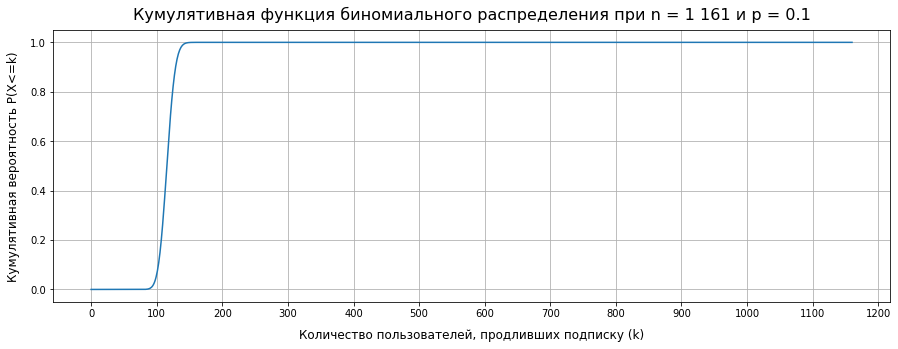

In [58]:
x = np.arange(0, 1161, 1)
y = binom.cdf(x, 1161, 0.1)

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.title('Кумулятивная функция биномиального распределения при n = 1 161 и p = 0.1', fontsize=16, pad=10)
plt.xlabel('Количество пользователей, продливших подписку (k)', fontsize=12, labelpad=10)
plt.ylabel('Кумулятивная вероятность P(X<=k)', fontsize=12, labelpad=10)
plt.xticks(range(0, 1300, 100))
plt.grid()
plt.show()

На графике видим: при k = 100 вероятность того, что X <= 99 действительно лежит в районе 5%, чего и требовалось достичь.

#### 7.2. Доп. задание отделу маркетинга 2

**Задание:**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Решение:**

В поставленной задаче мы вновь имеем дело с биномиальным распределением с параметрами *n* = 1 млн. и *p* = 0.4.

При такой большой выборке (n) имеет смысл аппроксимировать биномиальное распределение. Вероятность "успеха" (открытия push-уведомления) довольно велика, поэтому в данном случае условие хорошей аппроксимации биномиального распределения распределением Пуассона не соблюдается.

Проверим, можем ли мы аппроксимировать данное биномиальное распределение нормальным. Условием хорошей аппроксимации в данном случае считается то, что промежуток *E[X] +- 3 * сигма* биномиального распределения лежит в пределах от 0 до *n* (т.е. там, где биномиальное распределение определено).

Для биномиального распределения:
- **мат. ожидание** E[X] = n * p;
- **дисперсия** Var[X] = n * p * (1 - p);
- **станд. отклон.** sigma[X] = sqrt(n * p * (1 - p)).

Посчитаем данные значения.

In [59]:
n = 1000000
p = 0.4

exp_value = n * p
var = n * p * (1 - p)
sigma = sqrt(var)

print('Мат. ожидание биномиального распределения:', exp_value)
print('Стандартное отклонение биномиального распределения:', round(sigma, 2))

Мат. ожидание биномиального распределения: 400000.0
Стандартное отклонение биномиального распределения: 489.9


In [60]:
# проверим, соблюдается ли условие хорошей аппроксимации

low_limit = exp_value - 3 * sigma
high_limit = exp_value + 3 * sigma

print('Нижняя граница интервала E[X]-3*сигма:', round(low_limit, 2))
print('Врехняя граница интервала E[X]+3*сигма:', round(high_limit, 2))
print()

if low_limit >= 0 and high_limit <= n:
    print('Условие хорошей аппроксимации соблюдается')
else:
    print('Условие хорошей аппроксимации не соблюдается')

Нижняя граница интервала E[X]-3*сигма: 398530.31
Врехняя граница интервала E[X]+3*сигма: 401469.69

Условие хорошей аппроксимации соблюдается


Как видим из результатов проверки, **биномиальное распределение в рамках задачи можно аппроксимировать нормальным**.

В таком случае нам необходимо проанализировать нормальное распределение случайной переменной *X* ~ *N*(400000, 489.9) и выяснить, какова вероятность того, что *X* <= 399,5 тыс (т.е. вероятность того, что push-уведомление откроют не более 399,5 тыс. пользователей).

In [61]:
# зададим нормальное распределение с тем же мат. ожиданием и станд. отклонением,
# что и у изначального биномиального распределения
norm_distr = st.norm(exp_value, sigma)

# зададим границу интервала, которая нас интересует (X <= x)
x = 399500

# найдём вероятность того, что X <= x
result = norm_distr.cdf(x)
print('Вероятность того, что письмо откроют не более 399,5 тыс. пользователей:',
      round(result*100, 1), '%')

Вероятность того, что письмо откроют не более 399,5 тыс. пользователей: 15.4 %


Осталось отобразить на графике оба распределения: биномиальное и нормальное.

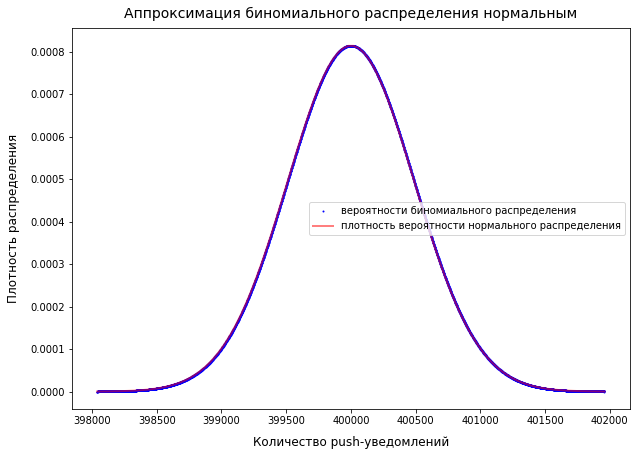

In [62]:
# зададим функцию, которая выдаёт <num> чисел, равномерно распределённых от <start> до <stop>,
# для визуализации нормального распределения

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(exp_value - 4 * sigma)
right = int(exp_value + 4 * sigma)
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))

# рисуем график биномиального распределения
plt.subplots(figsize=(10, 7))
ax = plt.subplot()

# используем синие о-образные маркеры и размер маркера 1
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=1, label='вероятности биномиального распределения')
 
# рисуем график нормального распределения: получим список из 100 чисел от left до right
x = linspace(left, right, 100)

# используем красную линию ширины 2 и прозрачности 0.5
ax.plot(x, norm.pdf(x, exp_value, sigma), 'r-', lw=2, alpha=0.5, \
        label='плотность вероятности нормального распределения')

# задаём название графика и осей
plt.title('Аппроксимация биномиального распределения нормальным', fontsize=14, pad=10)
plt.xlabel('Количество push-уведомлений', fontsize=12, labelpad=10)
plt.ylabel('Плотность распределения', fontsize=12, labelpad=10)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

На графике видно, что биномиальное распределение было очень хорошо аппроксимировано нормальным распределением: графики практически совпадают.

<a id=step8></a>
## Выводы исследования

В результате проведённого исследования было проанализировано три датафрейма:
1. users (информация о пользователях),
2. rides (информация о поездках),
3. subscriptions (информация о типах подписки).

На каждом из шагов исследования были достигнуты следующие результаты:
1. **Загрузка данных.** Импортированы необходимые библиотеки, загружены датафреймы.
2. **Предобработка данных:**
    - Скорректирован тип данных переменной *date* (дата поездки);
    - Создан новый столбец *month* с указанием месяца поездки;
    - Удалён 31 явный дубликат из датафрейма **users** и 95 аномальных значений в датафрейме **rides**.
3. **Исследовательский анализ данных.** Проанализированы переменные *city* (город совершения поездки), *subscription_type* (тип подписки), *age* (возраст пользователей), *distance* (расстояние, преодолённое в течение поездки), *duration* (длительность поездки).
4. **Объединение данных:**
    - Три датафрейма объединены в один (**data**);
    - На основе датафрейма *data* созданы 2 датафрейма: с информацией о пользователях с платной подпиской (*ultra*) и без платной подписки (*free*);
    - Визуализированы параметры *distance* и *duration* в разрезе типа подписки пользователей.
5. **Подсчёт выручки:**
    - Создан агрегированный датафрейм (**agg_data**), содержащий информацию о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
    - В новый датафрейм добавлен столбец *revenue*, рассчитывающий выручку на каждого пользователя в каждый месяц.
6. **Проверка гипотез.** Протестированы гипотезы:
    - о равенстве средней длительности поездки для пользователей с платной подпиской и без неё;
    - о равенстве среднего расстояния поездки для пользователя с платной подпиской конкретному числу (3 130 м);
    - о равенстве средней выручки, полученной от пользователей с платной подпиской и без неё.
7. **Анализ распределений:**
    - Выявлено количество промокодов на бесплатную подписку, которые необходимо разослать пользователям, чтобы с 95% вероятностью не менее 100 пользователей продлили подписку;
    - Выявлена вероятность того, что при рассылке 1 млн. push-уведомлений в мобильном приложении уведомление откроют не более 399,5 тыс. пользователей.

<a id='step9'></a>

### Ключевые выводы для бизнеса

**Основные выводы** исследования можно сформулировать следующим образом:
- **доля пользователей с подпиской составляет 45.6%** от всех пользователей сервиса;
- **больше всего пользователей находится в Пятигорске (14.3%)**, меньше - в Москве (11.0%);
- **половина всех пользователей** находится в возрастном диапазоне **от 22 до 28 лет**. **Средний возраст пользователя - 25 лет**;
- **расстояние**, которое проезжают пользователи, **сконцентрировано в двух пиках: ~700 м и ~3100 м**;
- в среднем каждый пользователь тратит на одну поездку **почти 18 мин**. Однако **пользователи с платной подпиской тратят на одну поездку больше времени**, чем пользователи без подписки;
-  с 90%-ной вероятностью в генеральной совокупности **пользователи с подпиской проезжают в среднем меньше 3 130 м за одну поездку** (оптимальное расстояние с точки зрения износа самоката);
- **ежемесячная выручка, получаемая от пользователей с платной подпиской, больше ежемесячной выручки, получаемой от пользователей без платной подписки**.

Полученные выводы говорят о **целесообразности распространения платной подписки** на сервис и **проведения мероприятий, направленных на увеличение количества пользователей, приобретающих платную подписку**.

**[В начало](#start)**